## CIFAR-10-Classification
We'll be using the CIFAR-10 dataset, which is very famous dataset for image recognition! 

The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images. 

The dataset is divided into five training batches and one test batch, each with 10000 images. The test batch contains exactly 1000 randomly-selected images from each class. The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another. Between them, the training batches contain exactly 5000 images from each class. 


## Step 0: Get the Data

** Download the data for CIFAR from here: https://www.cs.toronto.edu/~kriz/cifar.html **

**Specifically the CIFAR-10 python version link: https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz **

** Remember the directory you save the file in! **

In [1]:
# Put file path as a string here
CIFAR_DIR = '../data/cifar-10-batches-py'

The archive contains the files data_batch_1, data_batch_2, ..., data_batch_5, as well as test_batch. Each of these files is a Python "pickled" object produced with cPickle. 

** Load the Data. Use the Code Below to load the data: **

In [2]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        cifar_dict = pickle.load(fo)
    return cifar_dict

In [3]:
dirs = ['batches.meta','data_batch_1','data_batch_2','data_batch_3','data_batch_4','data_batch_5','test_batch']

In [4]:
all_data = [0,1,2,3,4,5,6]

In [5]:
for i,direc in zip(all_data,dirs):
    all_data[i] = unpickle(CIFAR_DIR+'/'+direc)

In [6]:
batch_meta = all_data[0]
data_batch1 = all_data[1]
data_batch2 = all_data[2]
data_batch3 = all_data[3]
data_batch4 = all_data[4]
data_batch5 = all_data[5]
test_batch = all_data[6]

In [7]:
batch_meta

{'label_names': ['airplane',
  'automobile',
  'bird',
  'cat',
  'deer',
  'dog',
  'frog',
  'horse',
  'ship',
  'truck'],
 'num_cases_per_batch': 10000,
 'num_vis': 3072}

** Why the 'b's in front of the string? **
Bytes literals are always prefixed with 'b' or 'B'; they produce an instance of the bytes type instead of the str type. They may only contain ASCII characters; bytes with a numeric value of 128 or greater must be expressed with escapes.

https://stackoverflow.com/questions/6269765/what-does-the-b-character-do-in-front-of-a-string-literal

In [8]:
all_data[1].keys()

['data', 'labels', 'batch_label', 'filenames']

Loaded in this way, each of the batch files contains a dictionary with the following elements:
* data -- a 10000x3072 numpy array of uint8s. Each row of the array stores a 32x32 colour image. The first 1024 entries contain the red channel values, the next 1024 the green, and the final 1024 the blue. The image is stored in row-major order, so that the first 32 entries of the array are the red channel values of the first row of the image.
* labels -- a list of 10000 numbers in the range 0-9. The number at index i indicates the label of the ith image in the array data.

The dataset contains another file, called batches.meta. It too contains a Python dictionary object. It has the following entries:

* label_names -- a 10-element list which gives meaningful names to the numeric labels in the labels array described above. For example, label_names[0] == "airplane", label_names[1] == "automobile", etc.

### Display a single image using matplotlib.

** Grab a single image from data_batch1 and display it with plt.imshow(). You'll need to reshape and transpose the numpy array inside the X = data_batch[b'data'] dictionary entry.**

** It should end up looking like this: **

    # Array of all images reshaped and formatted for viewing
    X = X.reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("uint8")

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [10]:
#concat all of the batches into a single train data matrix
train_data = all_data[1]['data'].reshape(10000, 3, 32, 32).transpose(0,2,3,1)
train_labels = np.array(all_data[1]['labels']).reshape(-1,1)
for data in all_data[2:6]:
    train_data = np.vstack((train_data, data['data'].reshape(10000, 3, 32, 32).transpose(0,2,3,1)))
    train_labels = np.vstack((train_labels, np.array(data['labels']).reshape(-1,1)))
print "train_data.shape={}, train_labels.shape={}".format(train_data.shape,train_labels.shape)

#concat all of the batches into a single test data matrix
test_data = all_data[6]['data'].reshape(10000, 3, 32, 32).transpose(0,2,3,1)
test_labels = np.array(all_data[6]['labels']).reshape(-1,1)
print "test_data.shape={}, test_labels.shape={}".format(test_data.shape,test_labels.shape)

train_data.shape=(50000, 32, 32, 3), train_labels.shape=(50000, 1)
test_data.shape=(10000, 32, 32, 3), test_labels.shape=(10000, 1)


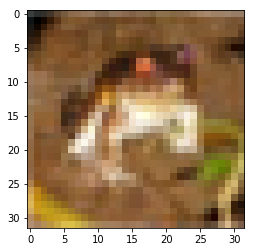

In [11]:
plt.imshow(train_data[0])

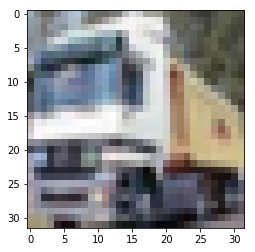

In [12]:
plt.imshow(train_data[1])

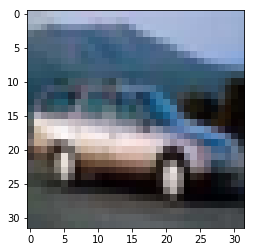

In [13]:
plt.imshow(train_data[4])

# Helper Functions for Dealing With Data.

** Use the provided code below to help with dealing with grabbing the next batch once you've gotten ready to create the Graph Session. Can you break down how it works? **

In [14]:
def one_hot_encode(vec, vals=10):
    '''
    For use to one-hot encode the 10- possible labels
    '''
    n = len(vec)
    out = np.zeros((n, vals))
    out[range(n), vec] = 1
    return out

In [15]:
class CifarHelper():
    
    def __init__(self):
        self.i = 0
        self.epochs = 0
        self._endBatch = False
    
        self.i_test = 0
        
        # Intialize some empty variables for later on
        self.training_images = None
        self.training_labels = None
        self.train_len = None
        
        self.test_images = None
        self.test_labels = None
        self.test_len = None
    
    def set_up_images(self):
        
        print("Setting Up Training Images and Labels")
        
        # normalizes training images
        self.training_images = train_data/255
        self.train_len = train_data.shape[0]

        # One hot Encodes the training labels (e.g. [0,0,0,1,0,0,0,0,0,0])
        self.training_labels = train_labels.astype(np.int32)
        
        print("Setting Up Test Images and Labels")
        
        # Vertically stacks the test images
        self.test_images = test_data/255
        self.test_len = test_data.shape[0]
        
        # One hot Encodes the test labels (e.g. [0,0,0,1,0,0,0,0,0,0])
        self.test_labels = test_labels.astype(np.int32)
        
    def resetBatch(self):
        '''
        reset all the indice of the data loader
        '''
        self.i = 0
        self.epochs = 0
        self._endBatch = False
        self.i_test = 0

        
    def next_batch_train(self, batch_size):
        ''' 
        retrieve the test batch, return the data, label and the current epoch
        '''
        if self._endBatch:
            self.i = 0
            self.epochs += 1
            self._endBatch = False
            
        nextIdx  = self.i+batch_size
        if nextIdx >= self.train_len:
            self._endBatch = True
            x = self.training_images[self.i:,:,:,:]
            y = self.training_labels[self.i:,:]
        else:
            x = self.training_images[self.i:nextIdx,:,:,:]
            y = self.training_labels[self.i:nextIdx,:]
            self.i = nextIdx
        return x, y.reshape(-1), self.epochs
    
    def next_batch_test(self, batch_size):
        ''' 
        retrieve the test batch, return the data, label and flag to determine 
        if the batch has reached the end of test data
        '''
        _endData = False
        nextIdx  = self.i_test + batch_size
        #print("self.i_test={}".format(self.i_test))
        if nextIdx >= self.test_len:
            x = self.test_images[self.i_test:,:,:,:]
            y = self.test_labels[self.i_test:,:]
            _endData = True
            self.i_test = 0
        else:
            x = self.test_images[self.i_test:nextIdx,:,:,:]
            y = self.test_labels[self.i_test:nextIdx,:]
            self.i_test = nextIdx
        return x, y.reshape(-1), _endData

** How to use the above code: **

In [16]:
# Before Your tf.Session run these two lines
ch = CifarHelper()
ch.set_up_images()

# During your session to grab the next batch use this line
# (Just like we did for mnist.train.next_batch)
# batch = ch.next_batch(100)

Setting Up Training Images and Labels
Setting Up Test Images and Labels


In [17]:
for i in range(10):
    x,y, epoch = ch.next_batch_train(10001)
    print "x.shape={}, y.shape={},ch.i={},epoch={}".format(x.shape,y.shape,ch.i,epoch)

x.shape=(10001, 32, 32, 3), y.shape=(10001,),ch.i=10001,epoch=0
x.shape=(10001, 32, 32, 3), y.shape=(10001,),ch.i=20002,epoch=0
x.shape=(10001, 32, 32, 3), y.shape=(10001,),ch.i=30003,epoch=0
x.shape=(10001, 32, 32, 3), y.shape=(10001,),ch.i=40004,epoch=0
x.shape=(9996, 32, 32, 3), y.shape=(9996,),ch.i=40004,epoch=0
x.shape=(10001, 32, 32, 3), y.shape=(10001,),ch.i=10001,epoch=1
x.shape=(10001, 32, 32, 3), y.shape=(10001,),ch.i=20002,epoch=1
x.shape=(10001, 32, 32, 3), y.shape=(10001,),ch.i=30003,epoch=1
x.shape=(10001, 32, 32, 3), y.shape=(10001,),ch.i=40004,epoch=1
x.shape=(9996, 32, 32, 3), y.shape=(9996,),ch.i=40004,epoch=1


In [18]:
#test the next_batch_test function 
for i in range(10):
    x,y, endTest = ch.next_batch_test(5000)
    print "x.shape={}, y.shape={},ch.i_test={},ch.epochs={}".format(x.shape,y.shape,ch.i_test,ch.epochs)
    if endTest:
        break

x.shape=(5000, 32, 32, 3), y.shape=(5000,),ch.i_test=5000,ch.epochs=1
x.shape=(5000, 32, 32, 3), y.shape=(5000,),ch.i_test=0,ch.epochs=1


In [19]:
ch.resetBatch()

## Creating the Model

** Import tensorflow **

In [20]:
import tensorflow as tf

Couldn't import dot_parser, loading of dot files will not be possible.


** Create 2 placeholders, x and y_true. Their shapes should be: **

* x shape = [None,32,32,3]
* y_true shape = [None,10]


In [21]:
x = tf.placeholder(dtype=tf.float32,shape=[None,32,32,3])
y = tf.placeholder(dtype=tf.int32,shape=[None])
y_one_hot = tf.one_hot(y,depth=10)

** Create one more placeholder called hold_prob. No need for shape here. This placeholder will just hold a single probability for the dropout. **

In [22]:
hold_prob = tf.placeholder(dtype=tf.float32)

### Helper Functions

** Grab the helper functions from MNIST with CNN (or recreate them here yourself for a hard challenge!). You'll need: **

* init_weights
* init_bias
* conv2d
* max_pool_2by2
* convolutional_layer
* normal_full_layer

### Create the Layers

** Create a convolutional layer and a pooling layer as we did for MNIST. **
** Its up to you what the 2d size of the convolution should be, but the last two digits need to be 3 and 32 because of the 3 color channels and 32 pixels. So for example you could use:**

        convo_1 = convolutional_layer(x,shape=[4,4,3,32])

In [23]:
with tf.name_scope('conv1'):
    # conv input[32,32,3] -> output [32,32,32]
    w = tf.Variable(initial_value=tf.truncated_normal([5,5,3,32],stddev=0.1,mean=0),name='w')
    b = tf.Variable(initial_value=tf.zeros(shape=[32]),name='b')
    logits = tf.nn.conv2d(x,filter=w,strides=[1,1,1,1],padding='SAME',name='conv')
    logits = tf.add(logits,b,name='add')
    logits = tf.nn.relu(logits,name='relu')

    # pool input [32,32,32] -> output [16,16,32]
    logits = tf.nn.max_pool(logits,ksize=[1, 2, 2, 1],strides=[1, 2, 2, 1], padding='SAME',name='max_pool')

** Create the next convolutional and pooling layers.  The last two dimensions of the convo_2 layer should be 32,64 **

In [24]:
with tf.name_scope('conv2'):
    # conv input[16,16,32] -> output [16,16,64]
    w = tf.Variable(initial_value=tf.truncated_normal([5,5,32,64],stddev=0.1,mean=0),name='w')
    b = tf.Variable(initial_value=tf.zeros(shape=[64]),name='b')
    logits = tf.nn.conv2d(logits,filter=w,strides=[1,1,1,1],padding='SAME',name='conv')
    logits = tf.add(logits,b,name='add')
    logits = tf.nn.relu(logits,name='relu')

    # pool input [16,16,64] -> output [8,8,64]
    logits = tf.nn.max_pool(logits,ksize=[1, 2, 2, 1],strides=[1, 2, 2, 1], padding='SAME',name='max_pool')




** Now create a flattened layer by reshaping the pooling layer into [-1,8 \* 8 \* 64] or [-1,4096] **

In [25]:
#flatten layer input [8,8,64] -> output [-1,8*8*64]
logits = tf.reshape(logits,shape=[-1,4096],name='flatten')

In [26]:
with tf.name_scope('fc1'):
    # #fc layer input [4096] -> output [1024]
    w = tf.Variable(initial_value=tf.truncated_normal([4096,1024],stddev=0.1,mean=0),name='w')
    b = tf.Variable(initial_value=tf.zeros(shape=[1]),name='b')
    logits = tf.add(tf.matmul(logits,w,name="mul"),b,name='add')
    logits = tf.nn.relu(logits,name='relu')

** Create a new full layer using the normal_full_layer function and passing in your flattend convolutional 2 layer with size=1024. (You could also choose to reduce this to something like 512)**

In [27]:
with tf.name_scope('fc2'):
    # #fc layer input [1024] -> output [512]
    w = tf.Variable(initial_value=tf.truncated_normal([1024,512],stddev=0.1,mean=0),name='w')
    b = tf.Variable(initial_value=tf.zeros(shape=[1]),name='b')
    logits = tf.add(tf.matmul(logits,w,name="mul"),b,name='add')
    logits = tf.nn.relu(logits,name='relu')

** Now create the dropout layer with tf.nn.dropout, remember to pass in your hold_prob placeholder. **

In [28]:
#dropout
logits = tf.nn.dropout(logits,keep_prob=hold_prob,name='dropout')

** Finally set the output to y_pred by passing in the dropout layer into the normal_full_layer function. The size should be 10 because of the 10 possible labels**

In [29]:
#fc layer input [512] -> output [10]
with tf.name_scope('classification'):
    # #fc layer input [512] -> output [10]
    w = tf.Variable(initial_value=tf.truncated_normal([512,10],stddev=0.1,mean=0),name='w')
    b = tf.Variable(initial_value=tf.zeros(shape=[1]),name='b')
    logits = tf.add(tf.matmul(logits,w,name="mul"),b,name='add')

### Loss Function

** Create a cross_entropy loss function **

In [30]:
cross_ent = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits,labels=y_one_hot))

### Optimizer
** Create the optimizer using an Adam Optimizer. **

In [31]:
optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
trainer = optimizer.minimize(cross_ent)

** Create Evaluator. **

In [32]:
pred = tf.argmax(tf.nn.softmax(logits),axis=1)
acc = tf.reduce_mean(tf.cast(tf.equal(tf.cast(pred,dtype=tf.float32),tf.cast(y,dtype=tf.float32)),dtype=tf.float32))

** Create a variable to intialize all the global tf variables. **

In [33]:
init = tf.global_variables_initializer()

## Graph Session

** Perform the training and test print outs in a Tf session and run your model! **

In [34]:
ch.resetBatch()
NUM_EPOCHS = 10
BATCH_SIZE = 100
current_epoch, next_epoch = 0, 1
step = 0
with tf.Session() as sess:
    sess.run(init)
    while(current_epoch < NUM_EPOCHS):
        x_train, y_train, current_epoch = ch.next_batch_train(BATCH_SIZE)
        sess.run([trainer],feed_dict={x:x_train,y:y_train,hold_prob:1.0})
        
        #if current_epoch == next_epoch:
        if step%1000 == 0:
            endTestBatch = False
            test_acc = 0
            count = 0
            while(not endTestBatch):
                x_test, y_test, endTestBatch = ch.next_batch_test(BATCH_SIZE)
                acc_val = sess.run([acc],feed_dict={x:x_test,y:y_test,hold_prob:1.0})
                test_acc += acc_val[0]*x_test.shape[0]
                count += x_test.shape[0]
            test_acc /= count
            print("Acc @iteration{} @epoch {} is {}...".format(step,current_epoch,test_acc))
            next_epoch += 1
        step += 1


Acc @iteration0 @epoch 0 is 0.114599999785...
Acc @iteration1000 @epoch 2 is 0.152600000724...
Acc @iteration2000 @epoch 4 is 0.146100000367...
Acc @iteration3000 @epoch 6 is 0.141600000262...
Acc @iteration4000 @epoch 8 is 0.159500000551...
Acc @iteration5000 @epoch 10 is 0.161000000089...
